# Module 2 Project Submission

* Student name: Miya Kusumoto
* Student pace: self paced
* Scheduled project review date/time: TBD
* Instructor name: Eli Thomas

## Introduction
miya complete this

In [28]:
##import statements
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sqlalchemy
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base

from mpl_toolkits.basemap import Basemap

import scipy.stats as st
from scipy.stats import kurtosis
from scipy.stats import skew

import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



# Part 1: Obtain, Scrub, Explore

We will begin by obtaining our dataset. The steps that we have to take to acquire our data include: 
* Utilize SQL Alchemy to connect to the Northwind DB
* Use SQLAlchemy Session Objects to map our database to python classes
* Create a DataFrame from the necessary tables so that we can clean it up and analyze

Because our data is stored in a database and we do not want to pull in every table every time, we will repeat parts of this process for each of test question we decide to answer. 

In [2]:
#Utilize sqlalchemy to connect to our db
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
#use inspector to get table names and understand what information is included in the database.
inspector = inspect(engine)

print(inspector.get_table_names())

2019-04-06 08:19:37,818 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-06 08:19:37,819 INFO sqlalchemy.engine.base.Engine ()
2019-04-06 08:19:37,821 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-06 08:19:37,822 INFO sqlalchemy.engine.base.Engine ()
2019-04-06 08:19:37,825 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-06 08:19:37,826 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


### Table Names are: 
- Category
- Customer
- CustomerCustomerDemo
- CustomerDemographic
- Employee
- EmployeeTerritory
- Order
- OrderDetail
- Product
- Region
- Shipper
- Supplier
- Territory

Now that we have the table names, we can check with the ERD to ensure that everything checks out. We can see that there are quite a few discrepancies in our table names. 

Looks like table names in the ERD are plural where in our actual DB they are singular. We will have to keep an eye on that when we begin to work with the tables. 

It is good that we now have a list of the exact column names included in our database. We will rely heavily on this as we begin pulling together multiple tables to answer more complicated questions. 

In [4]:
#lets look at the columns and data types included in our OrderDetail table.
#For the initial question, this is what we will be focusing on. 

print(inspector.get_columns("OrderDetail"))

2019-04-06 08:19:42,422 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-04-06 08:19:42,422 INFO sqlalchemy.engine.base.Engine ()
[{'name': 'Id', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'OrderId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'ProductId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'UnitPrice', 'type': DECIMAL(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Quantity', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Discount', 'type': FLOAT(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


The current structure is messy; let's write a function that allows us to see the table names in a clean and well-organized manner. The structure of the output from our .get_columns function is a list of dictionaries. 

In [5]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for col in cols_list:
        print("Name: {} \t Type: {}".format(col['name'], col['type']))

get_columns_info('OrderDetail')

Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


Now that we are able to obtain basic information about all of the tables in the dataset, let's revisit the initial question. We do this because it is important to understand what information in what tables we will need to pull from our database.

### Revisit the Question: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

To answer this first question, we will likely only need the Order Detail table. As we were able to see from our exploration above, that table includes the **OrderID**, the **ProductID**, the **Unit Price**, the **Quantity**, and the **Discount**. This should be the extent of the information that we need in order to answer our question. 

Now let's get this OrderDetail table into a Pandas DataFrame so that we can easily explore and analyze it to hopefully answer our question. 

In [6]:
#This SQL query selects all rows and columns from my OrderDetail table and puts it into a dataframe. 

q = """SELECT * from OrderDetail"""

df1 = pd.read_sql_query(q, engine)
df1.head()

2019-04-06 08:26:59,715 INFO sqlalchemy.engine.base.Engine SELECT * from OrderDetail
2019-04-06 08:26:59,716 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
#what datatypes are each of my columns? I want to make sure they are casted correctly
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


Above, we see that most of our columns are cast correctly. THe only two that I would like to change are the **OrderID** and **ProductID**. In this case I would like to keep them categorical so I will convert them to strings.

In [8]:
df1["OrderId"] = df1["OrderId"].astype("str")
df1["ProductId"] = df1["ProductId"].astype("str")

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null object
ProductId    2155 non-null object
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 101.1+ KB


It appears that all my columns are the correct type and there are no missing values in any of the columns. Before we begin hypothesis testing, let's try to get a better understanding of what exactly is in each of the columns. Below I will describe the dataframe to see the mean, median, max, min, and standard deviation of my continuous variables. 

In [9]:
df1.describe()

,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,0.056167
std,29.827418,19.022047,0.083450
min,2.000000,1.000000,0.000000
25%,12.000000,10.000000,0.000000
50%,18.400000,20.000000,0.000000
75%,32.000000,30.000000,0.100000
max,263.500000,130.000000,0.250000


In [15]:
print(len(df1["Discount"].unique()))
print(df1["Discount"].unique())

11
[0.   0.15 0.05 0.2  0.25 0.1  0.02 0.03 0.04 0.06 0.01]


<Figure size 1440x1440 with 0 Axes>

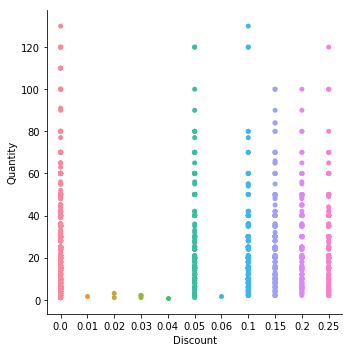

In [24]:
plt.figure(figsize = (20, 20))
sns.catplot(x="Discount", y="Quantity", jitter = False, data=df1);

In my description table, it doesn't appear that there are any outliers but the minimum price is \\$2 and the maximum price is \\$263.50. The majority of our products seem to be priced much lower in the \\$12 - \\$18 range. 

Quantities look pretty standard where most orders contain product quantities between 10 and 30 units. 

The Discount is more interesting and harder to understand based on the initial Describe output. To get insight into what discounts are present in the orders, I will check the unique values. There are 11 different discount percentages ranging from **0% (no discount) to 25%**. From the looks of my small visualization to better explain this, it appears that the majority of discounts fall in the **0%**, **5%**, **10%**, **15%**, **20%**, and **25%** buckets. 

To begin our hypothesis testing, we first need to see the distribution of the data so we know if our data is normally distributed.

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Quantity of Product Ordered')

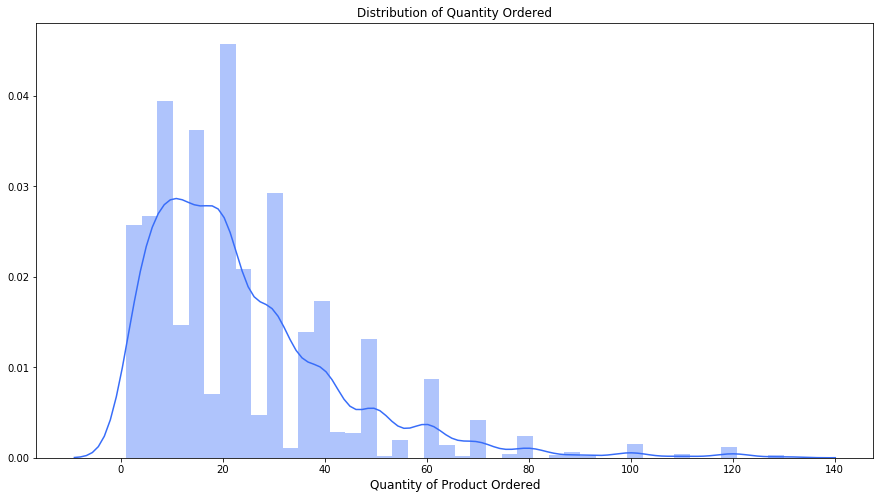

In [23]:
#visualize the distribution of the Quantity column
sns.set_palette('rainbow')

plt.figure(figsize=(15, 8))
sns.distplot(df1['Quantity']);
plt.title('Distribution of Quantity Ordered', fontsize=12)
plt.xlabel('Quantity of Product Ordered', fontsize=12)

The quanitiy of products ordered appears to be skewed to the right with varying quantities in between. Because it is not normally distributed, we will need to use the **Central Limit Theorem** to create a sample distribution of sample means that will be normally distributed so that we can utilize p-values and z-scores to answer our question. 

# Part 2: Experimental Design (Modeling + Interpreting)

Sound experimental design underpins every decision we make as a data scientist. To ensure my problem and experiment are set up properly, a few things will happen in this phase: 
 - **Control Group will be defined**: Our control group is the group that allows us to compare outcomes. In this case our control group will include orders with **no** discount. The control group is important because without it we would have no insight into how much of our results can be attributed to the discount. 
 - **Appropriate Sample Size**: Large sample sizes protect us from randomness and variance. 
 - **Reproducibility**: In this situation we won't have to focus on this too much, but we do want to ensure that this experiment has Reproducible Results. 

### Revisit the Question
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Definining the Hypothesis


**Null Hypothesis ($H_O: \mu1 <= \mu_2$)**: The treatment group with a discount will not purchase larger quantities of a product in an order.

**Alternative Hypothesis ($H_a: \mu_1 > \mu_2$)**: The treatment group with a discount will purchase larger quantities of products in an order.

In this experiment I will be conducting a **_One-Tail Test_** because I want to know if the quantity of products in an order from the treatment group (orders **_with_** discount) is greater than the quantity of products per order from our control group (orders **_without_** discount). 

In this experiment we will also be dealing with **_Discrete_** data because the quantity of products in each order are integers. You can not by half of a product. 

With this in mind, we know we conducting an **Upper/Right-Tailed** test.

### Test our Hypothesis: 
1. Divide our data into two groups: the **treatment group** and the **contol group**.
2. Check for **normality**. If our data is not normal (which we know from above, we will need to create a normal sample distribution.
3. Caluculate a few sample statistics: 
 - The population mean (μ).
 - The sample mean (x̄). Calculate from the sample data
 - The sample standard deviation (sigma). Calculate from sample data
 - Number of observations(n). Calculated from the sample data.
 - Degrees of Freedom(df). Calculate from the sample as df = total no. of observations - 1
4. Calcluate the **t-value** (because at this point we will know our normality, independence, and randomness requirements are satisfied)
5. Find the **Critical T-Value**
6. Compare t-values to accept or reject the Null Hypothesis ($H_O$)
7. Check for Type 1 and Type 2 Errors (and ensure a 95% confidence level is correct)




### 1. Treatment Group and Control Group
To be able to run our experiment, we need to divide our data into the treatment and control groups. 
 - The **Control Group** includes all item/quantity pairs where **_no_** discount was received
 - The **Treatment Group** is exactly the opposite and includes all item/quantity pairs where **_any_** discount was received. 

In [26]:
#Create my control and treatment groups by dividing up my dataframe
control = df1[df1['Discount'] == 0]
control = control['Quantity']
treatment = df1[df1['Discount'] != 0]
treatment = treatment['Quantity']

### Normality 
Before we can make use of the normal distribution, we need to first confirm that our data is normally distributed. If it is not, then we'll need to use the Central Limit Theorem to create a sample distribution of sample means that will be normally distributed.

There are two main ways to check if a sample follows the normal distribution or not. The easiest is to simply plot the data and visually check if the data follows a normal curve or not.

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


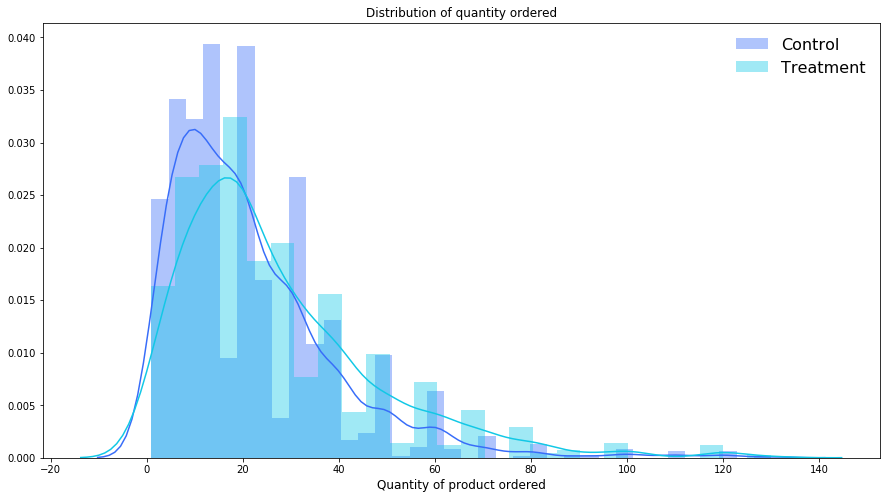

In [27]:
#First I will check normality visually
plt.figure(figsize=(15, 8))
sns.distplot(control, label='Control')
sns.distplot(treatment, label='Treatment')
plt.title('Distribution of quantity ordered', fontsize=12)
plt.xlabel('Quantity of product ordered', fontsize=12)
plt.legend(frameon=False, fontsize=16, loc='best')

In [30]:
#check normality using scipy normaltest function
print("Control:", st.normaltest(control))
print("Treatment:", st.normaltest(treatment))

Control: NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Treatment: NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


Given the obvious visual cues that our data is not normal paired with our very low p-values for each group, we know that our data is not normally distributed. 

With that in mind, we'll need to use the Central Limit Theorem.

### Sampling with Replacement
In order to create a Sample Distribution of Sample Means, we need to first write a function that can sample with replacement.

The cell below returns a random sample of our data. 

In [31]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def get_sample_mean(sample):
    return sum(sample) / len(sample)

def create_sample_distribution(data, dist_size=1000, n=500):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

In [32]:
#create sample distributions
ctrl_sample = create_sample_distribution(control)
tmt_sample = create_sample_distribution(treatment)

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


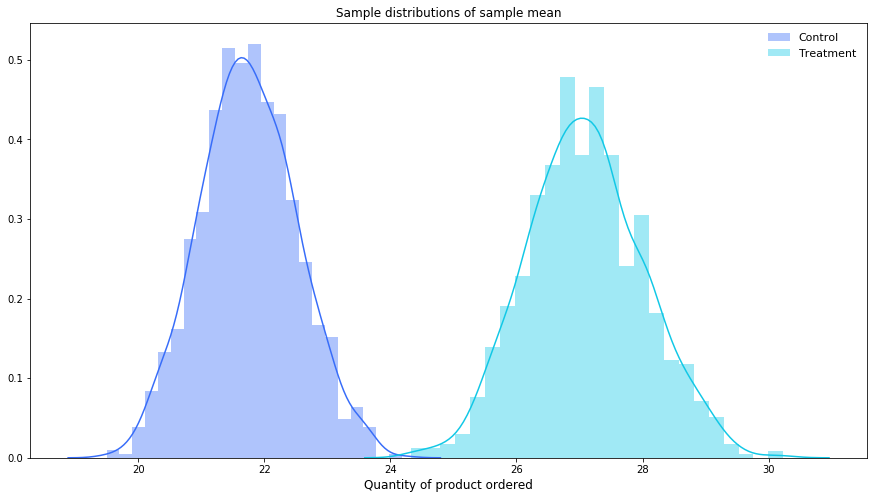

In [35]:
#Check and see if it worked!
plt.figure(figsize = (15, 8))
sns.distplot(ctrl_sample, label='Control')
sns.distplot(tmt_sample, label='Treatment')
plt.title('Sample distributions of sample mean', fontsize=12)
plt.xlabel('Quantity of product ordered', fontsize=12)
plt.legend(frameon=False, fontsize=11, loc='best')

In [ ]:
def one_sample_ttest(sample, population, alpha):

    # Visualize sample distribution for normality 
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(sample)
    
    # Population mean 
    mu = population.mean()
    
    # Sample mean (x̄) using NumPy mean()
    x_bar= sample.mean()

    # Sample Stadrad Deviation (sigma) using Numpy
    sigma = np.std(sample)
    
    # Degrees of freedom
    df = len(sample) - 1
    
    #Calculate the critical t-value
    t_crit = stats.t.ppf(1 - alpha, df=df)
    
    #Calculate the t-value and p-value
    results = stats.ttest_1samp(a= sample, popmean= mu)         
    
    if (results[0]>t_crit) and (results[1]<alpha):
        print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
                round(results[0], 2), "critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))
    else:
        print ("Null hypothesis is True with t-value =", 
                round(results[0], 2), ", critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))